In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
import pickle
import statsmodels.stats.multitest
from pymer4.models import Lmer # requires R + packages `lme4` and `lmerTest` (R version used here: 4.2.2)

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)

from utils import transform, plot
from modeling.check_fit import *

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 16, "font.family": "Asana Math", "figure.dpi": 192})
thcolor = "#44546A"

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# Figure 6. Optimal model parameters inter-relation and association with age in the PNC dataset

Load optimal simulations, demographics and other data needed:

In [3]:
parcels = transform.load_ordered_parcel_labels('schaefer-100')
elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "pnc_subs.csv"), index_col=0
).sort_index()

if os.path.exists('pnc_fc-sub_sc-sub_runs-2.csv') & os.path.exists('pnc_fc-sub_sc-sub_runs-2_vars.pkz'):
    subjects_optima = pd.read_csv('pnc_fc-sub_sc-sub_runs-2.csv', index_col=0)
    with open('pnc_fc-sub_sc-sub_runs-2_vars.pkz', 'rb') as f:
        regional_vars = pickle.load(f)
else:
    print("Run Figure 2 first")

best_runs = subjects_optima.groupby("sub")["gof"].idxmax().values
data = subjects_optima.loc[best_runs].set_index("sub")
data[["age", "sex", "group"]] = elig_subs.loc[data.index, ["age", "sex", "group"]]
data["Age (y)"] = data["age"] / 12

# add motion data
motion = pd.read_csv(
    os.path.join(OUTPUT_DIR["pnc"], 'postfmriprep', 'participants.tsv'), 
    delimiter="\t", index_col=0
).loc[data.index]
data = pd.concat([data, motion], axis=1)

In [4]:
param_dfs = {}

for param in ['wee', 'wei', 'wie']:
    param_dfs[param] = pd.DataFrame(index=data.index, columns=parcels, dtype=float)
    for i, parc in enumerate(parcels):
        for sub, row in data.iterrows():
            param_dfs[param].loc[sub, parc] = regional_vars[sub][row["SeedMW"]].loc[i, param]

## a. Inter-relation of parameters

### left: Correlation of G and mean regional parameters

In [5]:
mean_params = ['G', 'mean_wee', 'mean_wei', 'mean_wie']
mean_r = pd.DataFrame(index=mean_params, columns=mean_params, dtype=float)
mean_p = pd.DataFrame(index=mean_params, columns=mean_params, dtype=float)
for i, param_i in enumerate(mean_params):
    for j, param_j in enumerate(mean_params):
        if i > j:
            mean_r.loc[param_i, param_j] = scipy.stats.pearsonr(data[param_i], data[param_j]).statistic
            mean_p.loc[param_i, param_j] = scipy.stats.pearsonr(data[param_i], data[param_j]).pvalue
mean_r = mean_r.dropna(0, 'all').dropna(1, 'all')
mean_p = mean_p.dropna(0, 'all').dropna(1, 'all')
alpha = 0.05 / 6 # bonferroni
mean_sig = mean_p < alpha

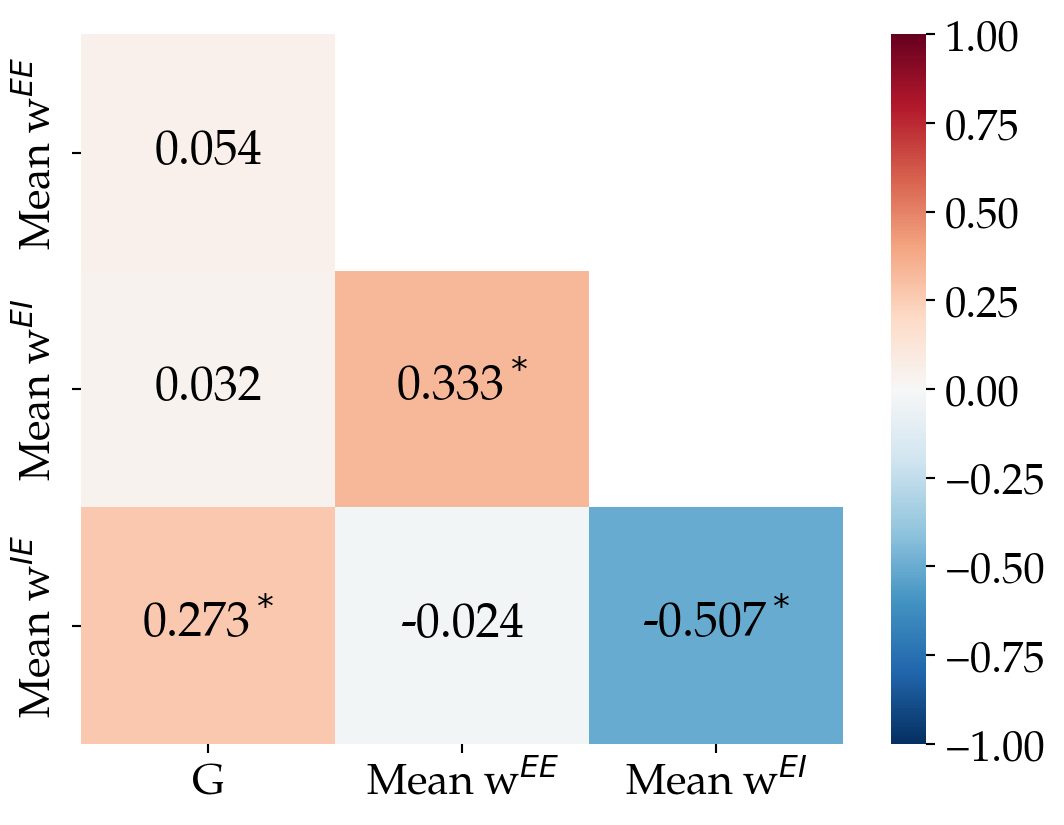

In [6]:
ax = sns.heatmap(mean_r.dropna(0, 'all').dropna(1, 'all'), cmap='RdBu_r', vmin=-1, vmax=1)
for x, col in enumerate(mean_r.columns):
    for y, row in enumerate(mean_r.index):
        if y >= x:
            text = f'{mean_r.loc[row, col]:.3f}'
            if mean_sig.loc[row, col]:
                text += r'$^*$'
            ax.text(x+0.5, y+0.5, 
                    text, 
                    fontsize=18,
                    horizontalalignment='center', 
                    verticalalignment='center')
ax.set_xticklabels(['G', r'Mean w$^{EE}$', r'Mean w$^{EI}$'])
ax.set_yticklabels([r'Mean w$^{EE}$', r'Mean w$^{EI}$', r'Mean w$^{IE}$']);

### right: Association of regional parameters across nodes and subjects

In [7]:
clean_names = {
    'G': 'G',
    'wee': r'$w^{EE}$',
    'wei': r'$w^{EI}$',
    'wie': r'$w^{IE}$',
}

long_df = pd.concat([param_dfs['wee'].unstack().reset_index(), 
                     param_dfs['wei'].unstack().reset_index(drop=True),
                     param_dfs['wie'].unstack().reset_index(drop=True)], 
                    axis=1)

long_df.columns = ['node', 'sub', 'wee', 'wei', 'wie']

#### $w^{EE}$ ~ $w^{EI}$

In [11]:
curr_p1 = 'wee'
curr_p2 = 'wei'
model = Lmer(f"{curr_p1} ~ {curr_p2} + (1 + {curr_p2} | node)", data=long_df)
print(model.fit())

r2 = 1 - (((model.residuals)**2).sum()) / (((long_df[curr_p1]-long_df[curr_p1].mean())**2).sum())
print("R2", r2)

Linear mixed model fit by REML [’lmerMod’]
Formula: wee~wei+(1+wei|node)

Family: gaussian	 Inference: parametric

Number of observations: 75200	 Groups: {'node': 100.0}

Log-likelihood: -53457.396 	 AIC: 106926.792

Random effects:

                 Name    Var    Std
node      (Intercept)  0.021  0.143
node              wei  0.018  0.133
Residual               0.241  0.490

              IV1  IV2   Corr
node  (Intercept)  wei -0.701

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)     0.656   0.627    0.685  0.015  98.743  44.074    0.0  ***
wei             0.230   0.202    0.257  0.014  97.947  16.608    0.0  ***
R2 0.10198331654524895


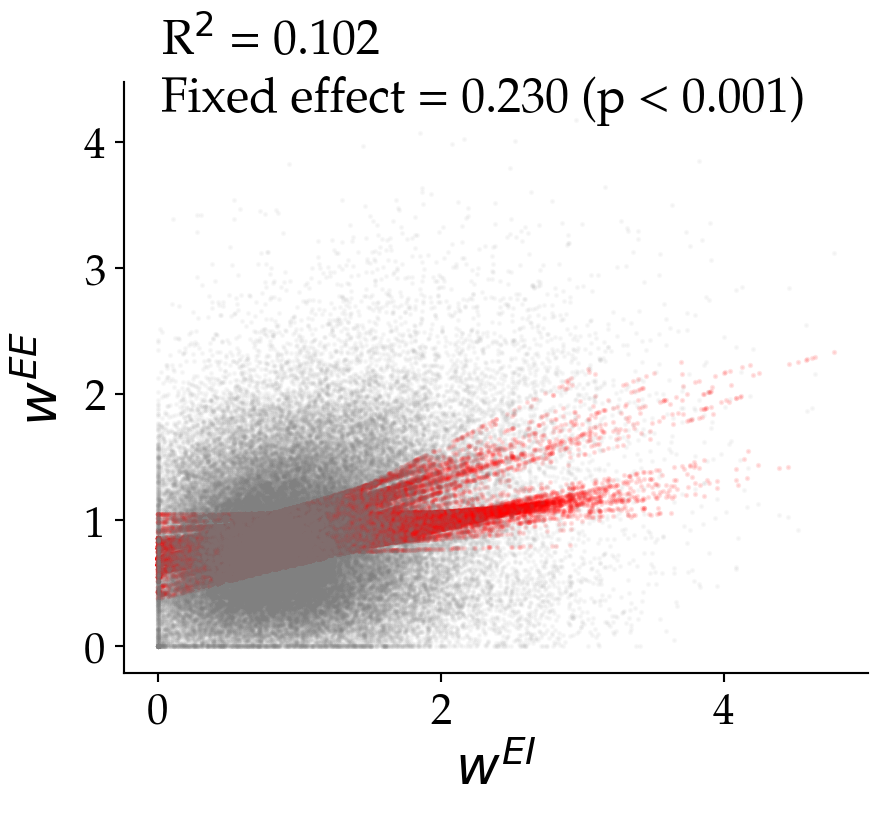

In [12]:
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(long_df[curr_p2], long_df[curr_p1]-model.residuals, s=1, color='red', alpha=0.1)
ax.scatter(long_df[curr_p2], long_df[curr_p1], s=1, color='grey', alpha=0.05)
ax.set_xlabel(clean_names[curr_p2], fontsize=20)
ax.set_ylabel(clean_names[curr_p1], fontsize=20)
text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
coef = model.coefs.loc[curr_p2, 'Estimate']
p = model.coefs.loc[curr_p2, 'P-val']
text = r'R$^2$ = 'f'{r2:.3f}\nFixed effect = {coef:.3f} ('
if p < 0.001:
    text += 'p < 0.001)'
else:
    text += f'p = {p:.3f})'
ax.text(text_x, text_y, text, color="black", size=18, multialignment="left")
sns.despine()

#### $w^{EE}$ ~ $w^{IE}$

In [13]:
curr_p1 = 'wee'
curr_p2 = 'wie'
model = Lmer(f"{curr_p1} ~ {curr_p2} + (1 + {curr_p2} | node)", data=long_df)
print(model.fit())

r2 = 1 - (((model.residuals)**2).sum()) / (((long_df[curr_p1]-long_df[curr_p1].mean())**2).sum())
print("R2", r2)

Linear mixed model fit by REML [’lmerMod’]
Formula: wee~wie+(1+wie|node)

Family: gaussian	 Inference: parametric

Number of observations: 75200	 Groups: {'node': 100.0}

Log-likelihood: -55842.488 	 AIC: 111696.975

Random effects:

                 Name    Var    Std
node      (Intercept)  0.026  0.162
node              wie  0.006  0.078
Residual               0.257  0.507

              IV1  IV2   Corr
node  (Intercept)  wie -0.815

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)     0.811   0.777    0.844  0.017  98.850  47.539    0.0  ***
wie             0.051   0.035    0.068  0.008  95.334   6.052    0.0  ***
R2 0.041859999572769535


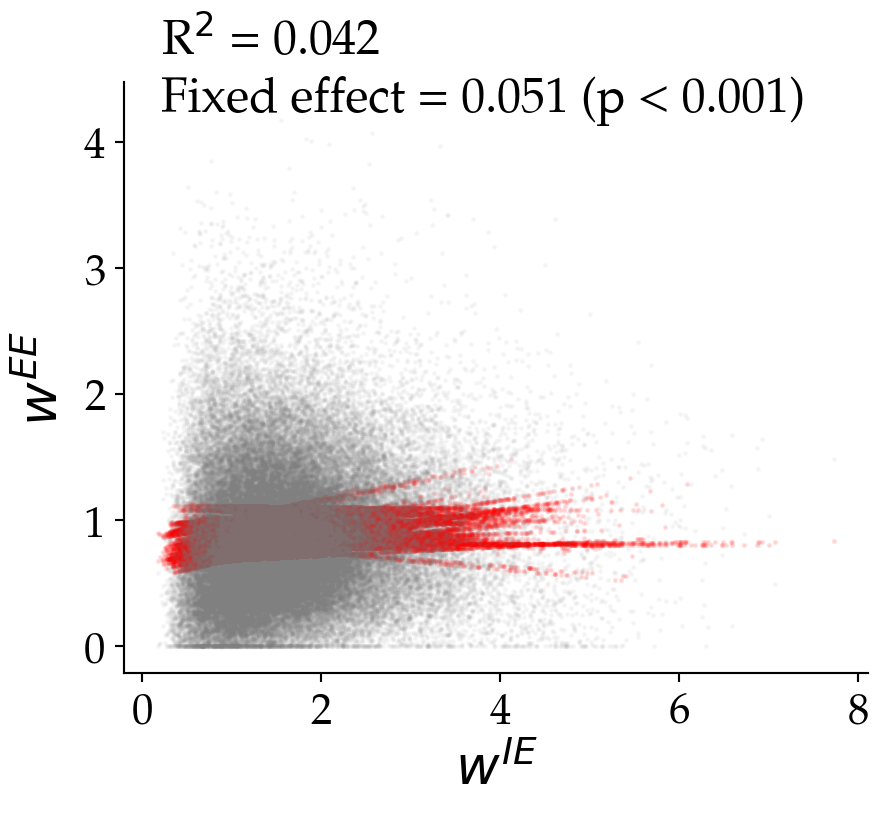

In [14]:
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(long_df[curr_p2], long_df[curr_p1]-model.residuals, s=1, color='red', alpha=0.1)
ax.scatter(long_df[curr_p2], long_df[curr_p1], s=1, color='grey', alpha=0.05)
ax.set_xlabel(clean_names[curr_p2], fontsize=20)
ax.set_ylabel(clean_names[curr_p1], fontsize=20)
text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
coef = model.coefs.loc[curr_p2, 'Estimate']
p = model.coefs.loc[curr_p2, 'P-val']
text = r'R$^2$ = 'f'{r2:.3f}\nFixed effect = {coef:.3f} ('
if p < 0.001:
    text += 'p < 0.001)'
else:
    text += f'p = {p:.3f})'
ax.text(text_x, text_y, text, color="black", size=18, multialignment="left")
sns.despine()

#### $w^{EI}$ ~ $w^{IE}$

In [16]:
curr_p1 = 'wei'
curr_p2 = 'wie'
model = Lmer(f"{curr_p1} ~ {curr_p2} + (1 + {curr_p2} | node)", data=long_df)
print(model.fit())

r2 = 1 - (((model.residuals)**2).sum()) / (((long_df[curr_p1]-long_df[curr_p1].mean())**2).sum())
print("R2", r2)

Linear mixed model fit by REML [’lmerMod’]
Formula: wei~wie+(1+wie|node)

Family: gaussian	 Inference: parametric

Number of observations: 75200	 Groups: {'node': 100.0}

Log-likelihood: -32170.953 	 AIC: 64353.905

Random effects:

                 Name    Var    Std
node      (Intercept)  0.094  0.307
node              wie  0.032  0.179
Residual               0.136  0.369

              IV1  IV2   Corr
node  (Intercept)  wie -0.706

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)     2.009   1.949    2.070  0.031  99.290  64.874    0.0  ***
wie            -0.632  -0.668   -0.597  0.018  98.115 -34.991    0.0  ***
R2 0.6068520852522312


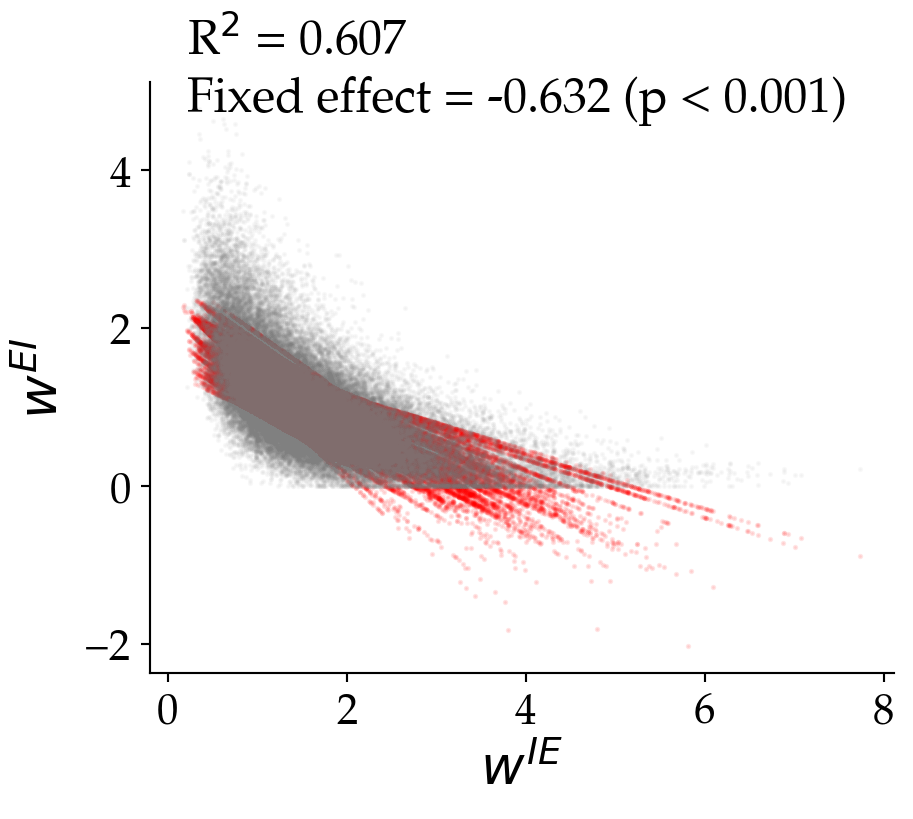

In [17]:
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(long_df[curr_p2], long_df[curr_p1]-model.residuals, s=1, color='red', alpha=0.1)
ax.scatter(long_df[curr_p2], long_df[curr_p1], s=1, color='grey', alpha=0.05)
ax.set_xlabel(clean_names[curr_p2], fontsize=20)
ax.set_ylabel(clean_names[curr_p1], fontsize=20)
text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
coef = model.coefs.loc[curr_p2, 'Estimate']
p = model.coefs.loc[curr_p2, 'P-val']
text = r'R$^2$ = 'f'{r2:.3f}\nFixed effect = {coef:.3f} ('
if p < 0.001:
    text += 'p < 0.001)'
else:
    text += f'p = {p:.3f})'
ax.text(text_x, text_y, text, color="black", size=18, multialignment="left")
sns.despine()

## b. Effect of age on optimal parameters

### $G$

In [18]:
# exclude outliers
curr_subs = data.index[(scipy.stats.zscore(data.loc[:, "G"]).abs() < 3)]
model_df = data.loc[curr_subs]
# fit the confound removal model to calculate pearson's r of the
# residual of I_E with age as an easy-to-interpret effect size
res_conf = smf.ols("G ~ gof + sex + mean_rms", data=model_df).fit()
model_df["resid"] = res_conf.resid
r_age = scipy.stats.pearsonr(model_df["age"], model_df["resid"]).statistic
# fit the main model
mod = smf.ols("G ~ age + gof + sex + mean_rms", data=model_df)
res = mod.fit()
print("Pearson's r", r_age)
print(res.summary())

Pearson's r -0.08454931702088742
                            OLS Regression Results                            
Dep. Variable:                      G   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     27.13
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           4.86e-21
Time:                        10:27:20   Log-Likelihood:                -615.79
No. Observations:                 751   AIC:                             1242.
Df Residuals:                     746   BIC:                             1265.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.16

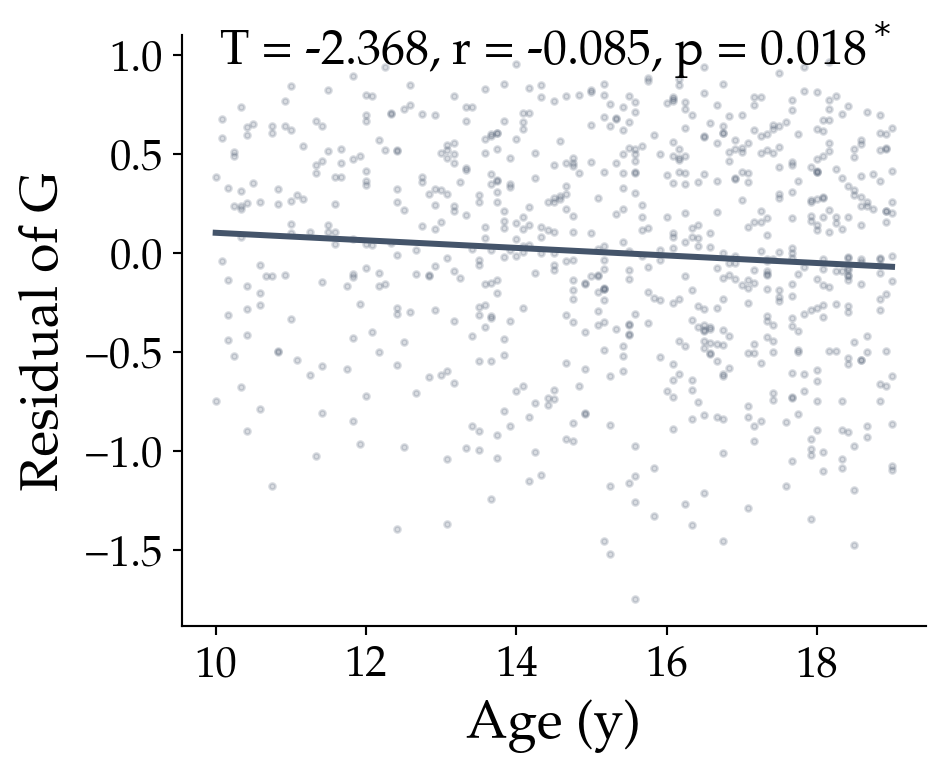

In [19]:
fig, ax = plt.subplots(figsize=(5, 4))
add_text = True

sns.regplot(
    model_df["Age (y)"],
    model_df["resid"],
    ax=ax,
    ci=None,
    scatter_kws=dict(color=thcolor, alpha=0.2, s=5),
    line_kws=dict(color=thcolor, alpha=1.0),
)
p = res.pvalues["age"]
t = res.tvalues["age"]
if add_text:
    text = f"T = {t:.3f}, r = {r_age:.3f}"
    if p > 0.001:
        text += f", p = {p:.3f}"
    else:
        text += ", p < 0.001"
    if p < 0.05:
        text += r"$^*$"
    text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
    text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
    ax.text(text_x, text_y, text, color="black", size=18, multialignment="left")
ax.set_ylabel(r"Residual of G", fontsize=20)
ax.set_xlabel("Age (y)", fontsize=20)
sns.despine()

### $w^{EE}$

In [30]:
curr_p = 'wee'
df = pd.concat([param_dfs[curr_p], data], axis=1)
df.columns = [f"node_{i}" for i in range(100)] + list(df.columns[100:])

t_age = pd.Series(index=parcels)
r_age = pd.Series(index=parcels)
p_age = pd.Series(index=parcels)
for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs = param_dfs[curr_p].index[(scipy.stats.zscore(param_dfs[curr_p].loc[:, parc]).abs() < 3)]
    model_df = df.loc[curr_subs]
    # fit the confound removal model to calculate pearson's r of the
    # residual of I_E with age as an easy-to-interpret effect size
    res_conf = smf.ols(f"node_{i} ~ gof + sex + mean_rms", data=model_df).fit()
    r_age.loc[parc] = scipy.stats.pearsonr(model_df["age"], res_conf.resid).statistic
    # fit the main model
    mod = smf.ols(f"node_{i} ~ age + gof + sex + mean_rms", data=model_df)
    res = mod.fit()
    t_age.loc[parc] = res.tvalues["age"]
    p_age.loc[parc] = res.pvalues["age"]

# FDR correction
_, p_age_fdr = statsmodels.stats.multitest.fdrcorrection(p_age)
p_age_fdr = pd.Series(p_age_fdr, index=parcels)

# display stats of signficant regions
stats_age = pd.DataFrame({"t": t_age, "r": r_age, "p": p_age, "p_fdr": p_age_fdr})
stats_age[stats_age["p_fdr"] < 0.05].sort_values(by="t").round(3)

,t,r,p,p_fdr


In [23]:
stats_age.to_csv(f"p_pnc_fc-sub_sc-sub_runs-2_{curr_p}_age_stats.csv")

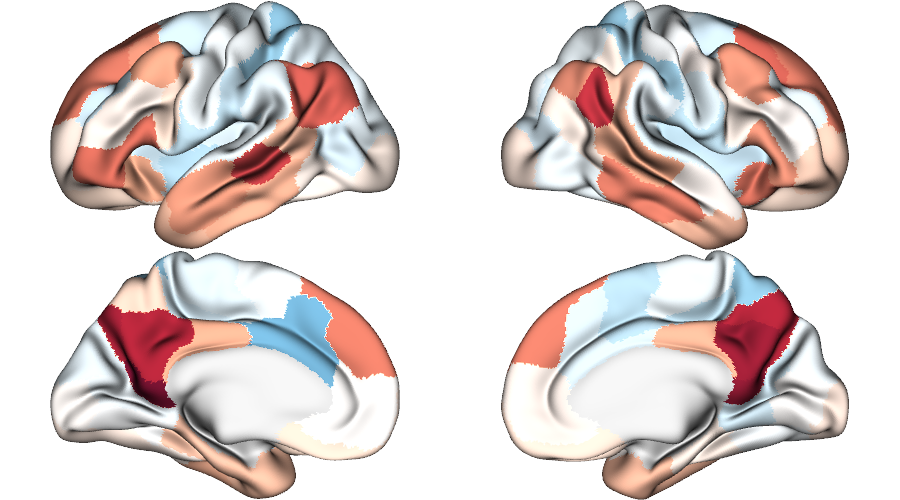

In [25]:
plot.plot_surface(
    transform.deparcellate_surf(t_age, "schaefer-100", concat=True, space="fsaverage"),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
)

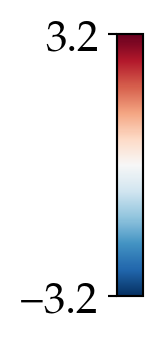

In [31]:
vmin = min(t_age.values.min(), -t_age.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));

### $w^{EI}$

In [26]:
curr_p = 'wei'
df = pd.concat([param_dfs[curr_p], data], axis=1)
df.columns = [f"node_{i}" for i in range(100)] + list(df.columns[100:])

t_age = pd.Series(index=parcels)
r_age = pd.Series(index=parcels)
p_age = pd.Series(index=parcels)
for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs = param_dfs[curr_p].index[(scipy.stats.zscore(param_dfs[curr_p].loc[:, parc]).abs() < 3)]
    model_df = df.loc[curr_subs]
    # fit the confound removal model to calculate pearson's r of the
    # residual of I_E with age as an easy-to-interpret effect size
    res_conf = smf.ols(f"node_{i} ~ gof + sex + mean_rms", data=model_df).fit()
    r_age.loc[parc] = scipy.stats.pearsonr(model_df["age"], res_conf.resid).statistic
    # fit the main model
    mod = smf.ols(f"node_{i} ~ age + gof + sex + mean_rms", data=model_df)
    res = mod.fit()
    t_age.loc[parc] = res.tvalues["age"]
    p_age.loc[parc] = res.pvalues["age"]

# FDR correction
_, p_age_fdr = statsmodels.stats.multitest.fdrcorrection(p_age)
p_age_fdr = pd.Series(p_age_fdr, index=parcels)

# display stats of signficant regions
stats_age = pd.DataFrame({"t": t_age, "r": r_age, "p": p_age, "p_fdr": p_age_fdr})
stats_age[stats_age["p_fdr"] < 0.05].sort_values(by="t").round(3)

,t,r,p,p_fdr
7Networks_RH_SomMot_8,-3.304,-0.118,0.001,0.034
7Networks_RH_SomMot_5,-3.298,-0.118,0.001,0.034
7Networks_LH_SomMot_5,-3.271,-0.117,0.001,0.034
7Networks_LH_SomMot_6,-3.160,-0.113,0.002,0.034
7Networks_RH_SomMot_6,-3.061,-0.109,0.002,0.034
7Networks_RH_Vis_7,-3.049,-0.110,0.002,0.034
7Networks_RH_SomMot_4,-2.958,-0.106,0.003,0.040
7Networks_LH_SomMot_4,-2.861,-0.103,0.004,0.044
7Networks_LH_Cont_PFCl_1,2.858,0.102,0.004,0.044
7Networks_LH_Default_PFC_3,3.057,0.110,0.002,0.034


In [27]:
stats_age.to_csv(f"p_pnc_fc-sub_sc-sub_runs-2_{curr_p}_age_stats.csv")

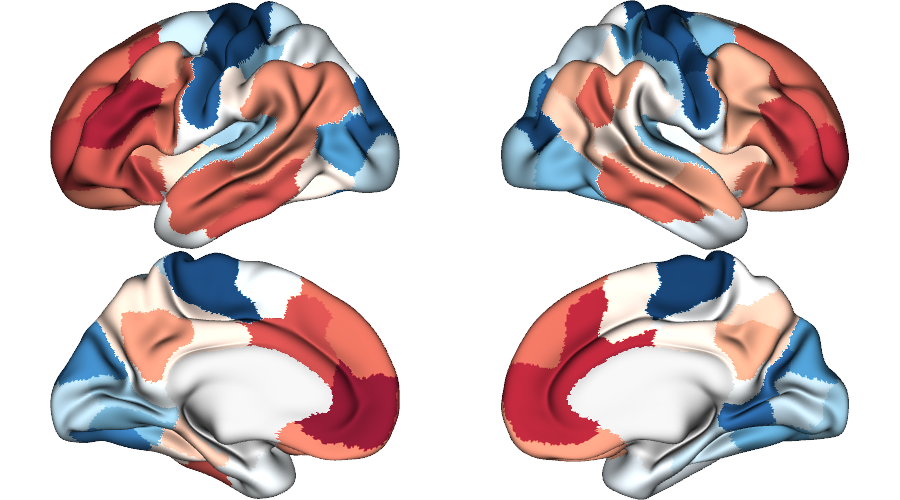

In [28]:
plot.plot_surface(
    transform.deparcellate_surf(t_age, "schaefer-100", concat=True, space="fsaverage"),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
)

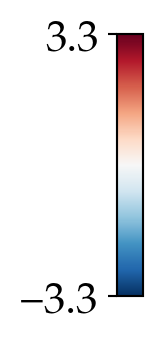

In [29]:
vmin = min(t_age.values.min(), -t_age.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));

### $w^{IE}$

In [32]:
curr_p = 'wie'
df = pd.concat([param_dfs[curr_p], data], axis=1)
df.columns = [f"node_{i}" for i in range(100)] + list(df.columns[100:])

t_age = pd.Series(index=parcels)
r_age = pd.Series(index=parcels)
p_age = pd.Series(index=parcels)
for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs = param_dfs[curr_p].index[(scipy.stats.zscore(param_dfs[curr_p].loc[:, parc]).abs() < 3)]
    model_df = df.loc[curr_subs]
    # fit the confound removal model to calculate pearson's r of the
    # residual of I_E with age as an easy-to-interpret effect size
    res_conf = smf.ols(f"node_{i} ~ gof + sex + mean_rms", data=model_df).fit()
    r_age.loc[parc] = scipy.stats.pearsonr(model_df["age"], res_conf.resid).statistic
    # fit the main model
    mod = smf.ols(f"node_{i} ~ age + gof + sex + mean_rms", data=model_df)
    res = mod.fit()
    t_age.loc[parc] = res.tvalues["age"]
    p_age.loc[parc] = res.pvalues["age"]

# FDR correction
_, p_age_fdr = statsmodels.stats.multitest.fdrcorrection(p_age)
p_age_fdr = pd.Series(p_age_fdr, index=parcels)

# display stats of signficant regions
stats_age = pd.DataFrame({"t": t_age, "r": r_age, "p": p_age, "p_fdr": p_age_fdr})
stats_age[stats_age["p_fdr"] < 0.05].sort_values(by="t").round(3)

,t,r,p,p_fdr
7Networks_RH_Default_Temp_2,2.197,0.079,0.028,0.050
7Networks_LH_Limbic_TempPole_1,2.211,0.079,0.027,0.049
7Networks_RH_Cont_PFCl_4,2.479,0.089,0.013,0.024
7Networks_RH_Cont_Par_2,2.527,0.091,0.012,0.022
7Networks_LH_Default_PFC_6,2.633,0.095,0.009,0.016
7Networks_RH_Default_pCunPCC_1,2.645,0.095,0.008,0.016
7Networks_RH_DorsAttn_FEF_1,2.652,0.095,0.008,0.016
7Networks_LH_SalVentAttn_ParOper_1,2.673,0.096,0.008,0.015
7Networks_LH_Default_PFC_1,2.684,0.096,0.007,0.015
7Networks_RH_DorsAttn_Post_1,2.701,0.097,0.007,0.015


In [33]:
stats_age.to_csv(f"p_pnc_fc-sub_sc-sub_runs-2_{curr_p}_age_stats.csv")

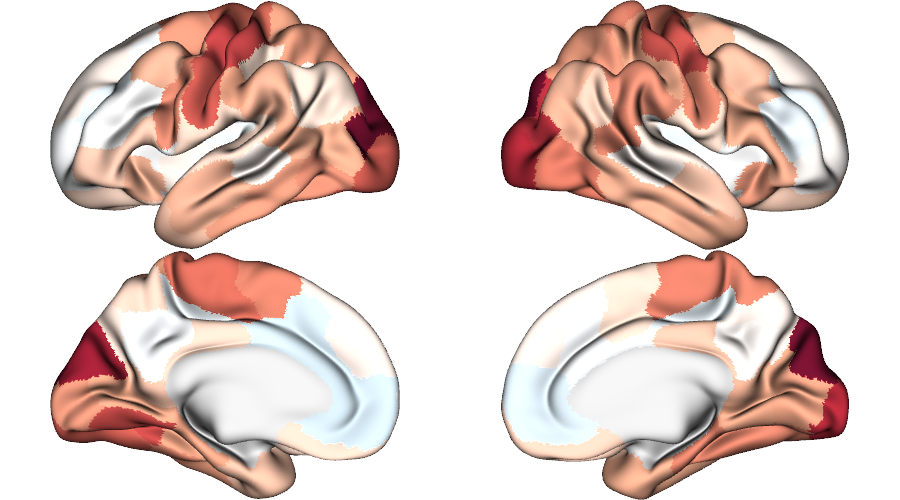

In [34]:
plot.plot_surface(
    transform.deparcellate_surf(t_age, "schaefer-100", concat=True, space="fsaverage"),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
)

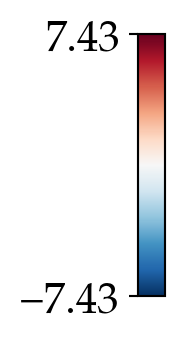

In [35]:
vmin = min(t_age.values.min(), -t_age.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));